In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [2]:
pip install statsmodels


     ---------------------------------------- 9.8/9.8 MB 231.2 kB/s eta 0:00:00
     ------------------------------------ 232.9/232.9 KB 268.9 kB/s eta 0:00:00


You should consider upgrading via the 'c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [9]:
df = pd.read_csv("synthetic_cbc_weekly_data.csv", parse_dates=["Timestamp"], index_col="Timestamp")
# df = df.asfreq('W')  # Ensure data is weekly
# df = df.fillna(method='ffill')  # Handle missing values by forward-filling
print(df.head())


            ID        WBC       LYMp       MIDp      NEUTp      LYMn  \
Timestamp                                                              
2000-01-01   1   6.621781  17.405317   5.402174  63.544605  3.087984   
2000-01-08   2  10.655000  31.676038   5.210724  67.883849  4.021729   
2000-01-15   3   9.123958  44.917833  13.781310  48.766376  3.840644   
2000-01-22   4   8.190609  39.288995   5.244101  61.870593  1.415600   
2000-01-29   5   5.092130  42.262446   5.535346  60.011109  1.396998   

                MIDn     NEUTn       RBC        HGB  ...        MCV  \
Timestamp                                            ...              
2000-01-01  0.651090  5.713670  3.885359  16.041875  ...  87.472816   
2000-01-08  0.762810  2.620511  4.210900  15.810981  ...  86.658242   
2000-01-15  1.296366  7.170565  5.628741  11.670279  ...  83.523078   
2000-01-22  0.576006  5.485256  5.486890  17.458007  ...  92.145333   
2000-01-29  1.317510  2.521825  4.571414  14.979305  ...  89.532483  

In [11]:


def check_stationarity(series, name):
    result = adfuller(series.dropna())  # Perform ADF test
    print(f"\n{name} - ADF Statistic: {result[0]}, P-Value: {result[1]}")
    if result[1] <= 0.05:
        print(f" {name} is stationary (No differencing needed).")
    else:
        print(f" {name} is NOT stationary (Differencing required).")

# Apply to all four columns
for col in ["RBC", "WBC", "HGB", "PLT"]:
    check_stationarity(df[col], col)



RBC - ADF Statistic: -20.077167988836973, P-Value: 0.0
 RBC is stationary (No differencing needed).

WBC - ADF Statistic: -30.46144987487421, P-Value: 0.0
 WBC is stationary (No differencing needed).

HGB - ADF Statistic: -33.34885270122613, P-Value: 0.0
 HGB is stationary (No differencing needed).

PLT - ADF Statistic: -14.049738103338475, P-Value: 3.193273003462403e-26
 PLT is stationary (No differencing needed).


In [13]:
for col in ["PLT"]:
    df[f"{col}_diff"] = df[col].diff().dropna()


In [15]:
for col in ["RBC", "WBC", "HGB", "PLT_diff"]:
    check_stationarity(df[col], col)



RBC - ADF Statistic: -20.077167988836973, P-Value: 0.0
 RBC is stationary (No differencing needed).

WBC - ADF Statistic: -30.46144987487421, P-Value: 0.0
 WBC is stationary (No differencing needed).

HGB - ADF Statistic: -33.34885270122613, P-Value: 0.0
 HGB is stationary (No differencing needed).

PLT_diff - ADF Statistic: -12.585769302423145, P-Value: 1.867457468478919e-23
 PLT_diff is stationary (No differencing needed).


In [ ]:


models = {}
for col in ["RBC", "WBC", "HGB", "PLT"]:
    d_value = 1 if df.dropna().shape[0] > 0 else 0  # Choose d based on stationarity
    models[col] = ARIMA(df[col], order=(2, d_value, 2)).fit()  # (p, d, q) = (2, d, 2)

# Display summaries
for col, model in models.items():
    print(f"\n### {col} ARIMA Model Summary ###")
    print(model.summary())


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\user\AppData\Local\Prog


### RBC ARIMA Model Summary ###
                               SARIMAX Results                                
Dep. Variable:                    RBC   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -951.384
Date:                Tue, 18 Feb 2025   AIC                           1912.769
Time:                        00:44:43   BIC                           1937.302
Sample:                    01-01-2000   HQIC                          1922.094
                         - 02-23-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.640     -0.995      0.320      -1.891       0.617
ar.L2         -0.0117      0.068     -0.172      0.864      -0.145       0.121
ma.L1         -0.42

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for each column
for col in models.keys():
    plt.figure(figsize=(10, 6))
    
    # Actual values
    plt.plot(df[col], label='Actual', color='blue', linestyle='-', linewidth=2)
    
    # Predicted values (forecasted)
    forecast_index = pd.date_range(df.index[-1], periods=future_steps + 1, freq='D')[1:]
    plt.plot(forecast_index, predictions[col], label='Predicted', color='red', linestyle='--', marker='o', linewidth=2)
    
    # Labels and title
    plt.title(f'Actual vs Predicted: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()


In [19]:
future_steps = 5
predictions = {}

for col, model in models.items():
    predictions[col] = model.forecast(steps=future_steps)

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions)
print(pred_df)


                 RBC       WBC        HGB         PLT
2019-03-02  4.937510  7.379867  14.295058  291.152130
2019-03-09  4.822379  7.464888  14.340028  300.481195
2019-03-16  4.885114  7.397887  14.473927  294.183970
2019-03-23  4.846505  7.465425  14.342865  300.385742
2019-03-30  4.870361  7.398302  14.461391  294.206276


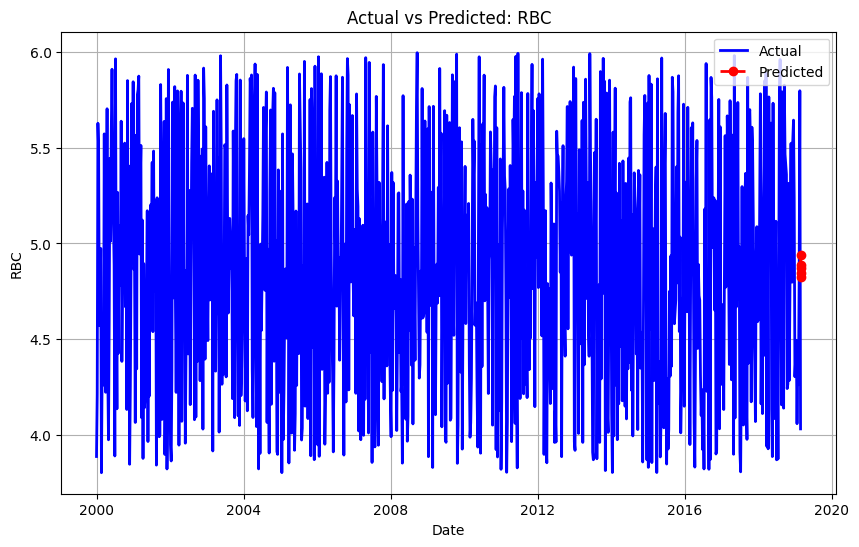

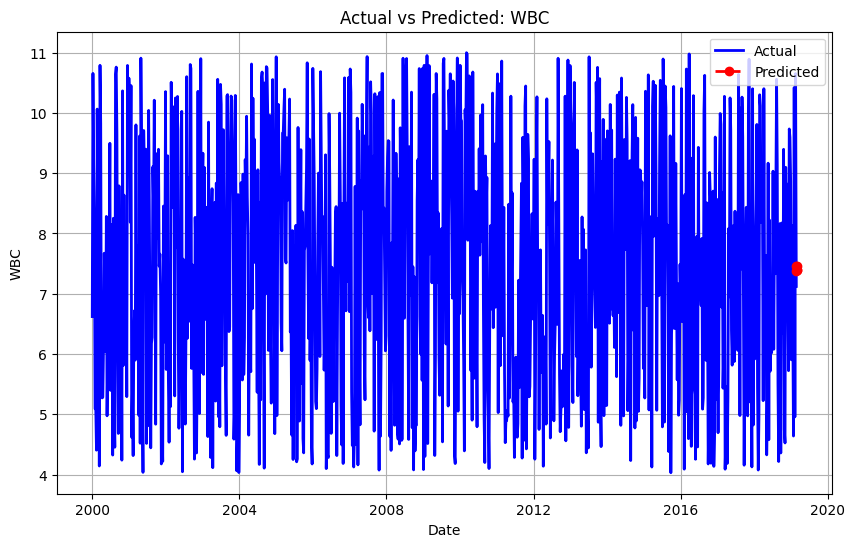

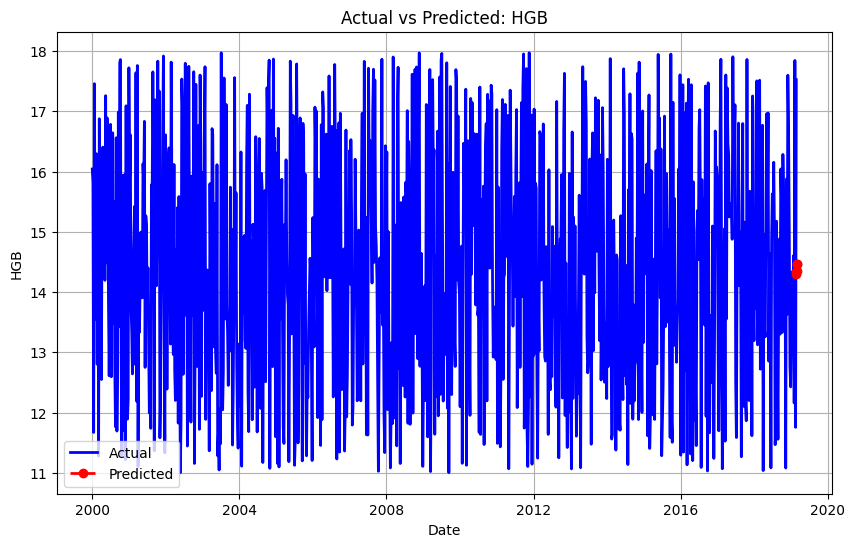

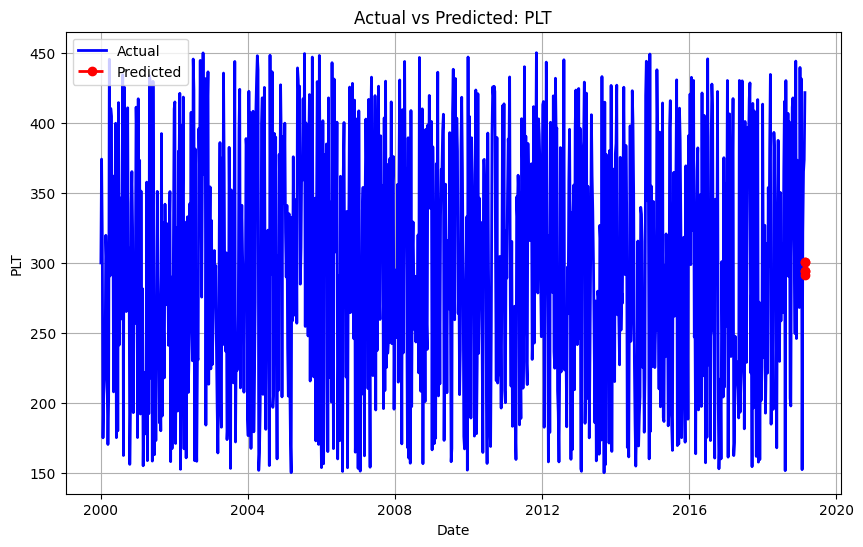

In [24]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for each column
for col in models.keys():
    plt.figure(figsize=(10, 6))
    
    # Actual values
    plt.plot(df[col], label='Actual', color='blue', linestyle='-', linewidth=2)
    
    # Predicted values (forecasted)
    forecast_index = pd.date_range(df.index[-1], periods=future_steps + 1, freq='D')[1:]
    plt.plot(forecast_index, predictions[col], label='Predicted', color='red', linestyle='--', marker='o', linewidth=2)
    
    # Labels and title
    plt.title(f'Actual vs Predicted: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

In [22]:
p, d, q = 2, 1, 2
model = ARIMA(df["RBC"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    RBC   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -951.384
Date:                Tue, 18 Feb 2025   AIC                           1912.769
Time:                        00:49:49   BIC                           1937.302
Sample:                    01-01-2000   HQIC                          1922.094
                         - 02-23-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.640     -0.995      0.320      -1.891       0.617
ar.L2         -0.0117      0.068     -0.172      0.864      -0.145       0.121
ma.L1         -0.4296      0.643     -0.668      0.5

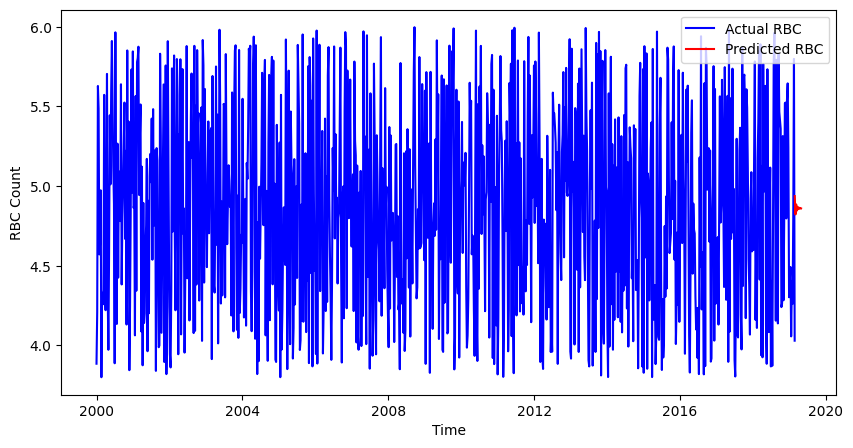

In [23]:
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(10,5))
plt.plot(df.index, df["RBC"], label="Actual RBC", color='blue')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='W'), forecast, label="Predicted RBC", color='red')
plt.xlabel("Time")
plt.ylabel("RBC Count")
plt.legend()
plt.show()